In [1]:
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from tabulate import tabulate
from src import camvid
from src import evaluate
from src import predict
from src import predict_video
from src.tiramisu import aleatoric_tiramisu
from src.tiramisu import tiramisu
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# the location to save coarse training weights to
pretrain_weights = 'models/Tiramisu103-CamVid11-fine.h5'
# the location to save fine training weights to
weights_file = 'models/Tiramisu103-CamVid11-Aleatoric.h5'

In [3]:
# the size to crop images to for fine tune training
crop_size = (352, 480)
# the size of batches to use for training
batch_size = 1

In [4]:
camvid11 = camvid.CamVid(
    mapping=camvid.load_mapping(),
    target_size=(360, 480),
    crop_size=crop_size,
    batch_size=batch_size,
    horizontal_flip=True,
    ignored_labels=['Void'],
    y_repeats=1,
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


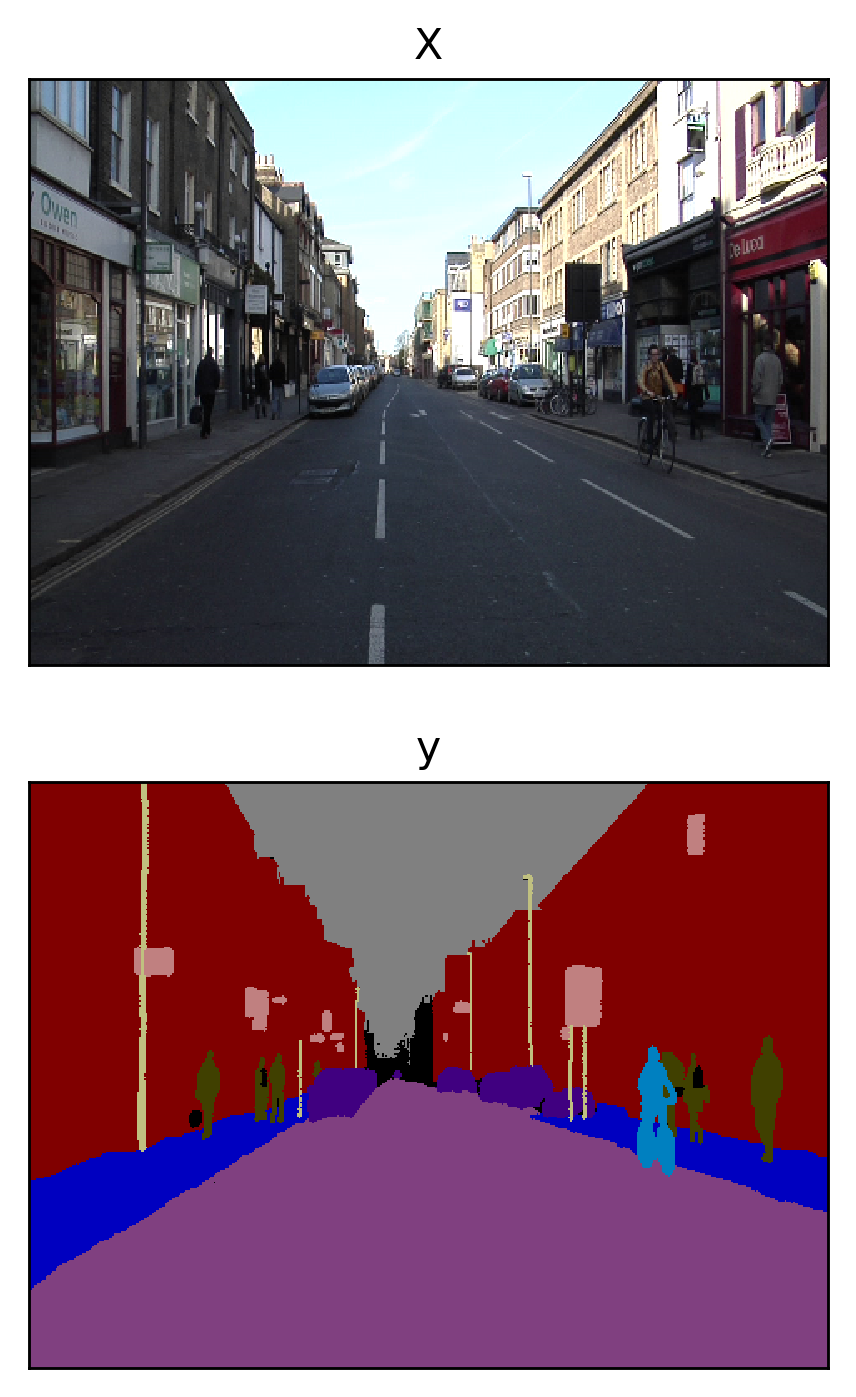

In [5]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y[0])
# plot the images
_ = camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [6]:
# build the model for the image shape and number of labels
model = aleatoric_tiramisu.aleatoric_tiramisu((*crop_size, 3), camvid11.n,
    class_weights=camvid11.class_mask,
    learning_rate=1e-4,
    weights_file=pretrain_weights,
)
model.summary()

/users/PMIU0138/miu0212/neural-semantic-segmentation/src/tiramisu/aleatoric_tiramisu.py:87: UserWarning: Output "sigma" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "sigma" during training.
  metrics={'softmax': [build_categorical_accuracy(weights=class_weights)]},


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 352, 480, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 480, 48) 1344        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 352, 480, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [7]:
callbacks = [
    EarlyStopping(monitor='val_aleatoric_loss', patience=10),
#     LearningRateScheduler(lambda _, lr: 0.995 * lr),
    ModelCheckpoint(weights_file,
        monitor='val_aleatoric_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    ),
    PlotMetrics(),
]

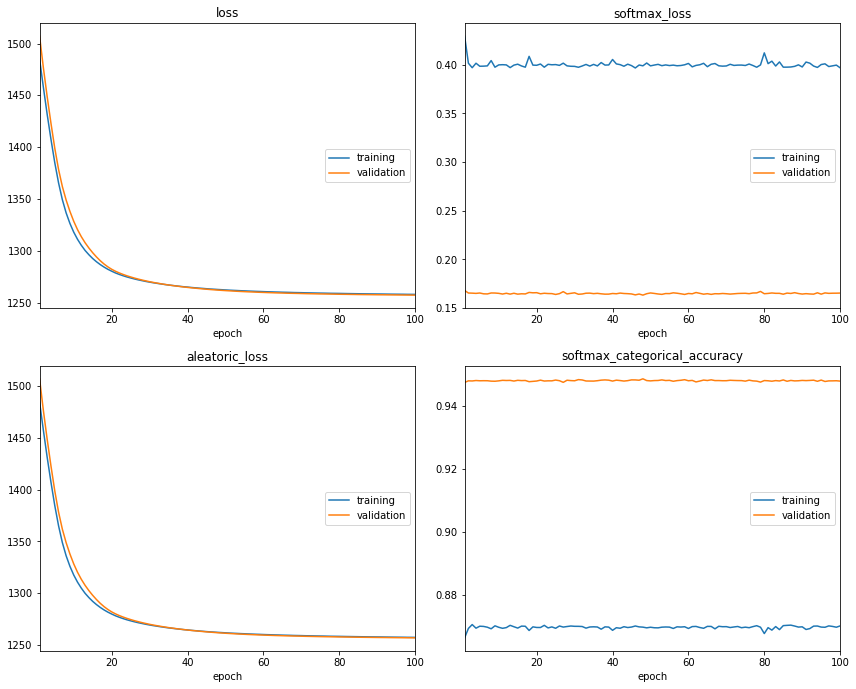

In [8]:
# fit the model with the data.
history = model.fit_generator(generators['train'],
    epochs=100,
    steps_per_epoch=int(367 / batch_size),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0,
)

In [9]:
history_to_results(history)

train          val
aleatoric_loss                1257.371709  1256.917543
loss                          1257.982271  1257.297606
softmax_categorical_accuracy     0.870291     0.948029
softmax_loss                     0.396871     0.165465

## Test Metrics

In [10]:
model.load_weights(weights_file)

In [11]:
metrics = evaluate.evaluate(model, generators['test'], 233,
    mask=camvid11.class_mask, 
    code_map=camvid11.discrete_to_label_map,
)
metrics.to_csv(weights_file + '.csv')
metrics

100%|██████████| 233/233 [01:20<00:00,  2.88step/s]


Test
Accuracy                 0.901727
Mean Per Class Accuracy  0.685065
Mean I/U                 0.567453
Bicyclist                0.332004
Building                 0.770349
Car                      0.668687
Column_Pole              0.257645
Fence                    0.247566
Pedestrian               0.429406
Road                     0.901876
Sidewalk                 0.769319
SignSymbol               0.221980
Sky                      0.921203
VegetationMisc           0.721953

In [12]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.901727 |
| Mean Per Class Accuracy | 0.685065 |
| Mean I/U                | 0.567453 |
| Bicyclist               | 0.332004 |
| Building                | 0.770349 |
| Car                     | 0.668687 |
| Column_Pole             | 0.257645 |
| Fence                   | 0.247566 |
| Pedestrian              | 0.429406 |
| Road                    | 0.901876 |
| Sidewalk                | 0.769319 |
| SignSymbol              | 0.22198  |
| Sky                     | 0.921203 |
| VegetationMisc          | 0.721953 |


## Qualitative Results

### Train

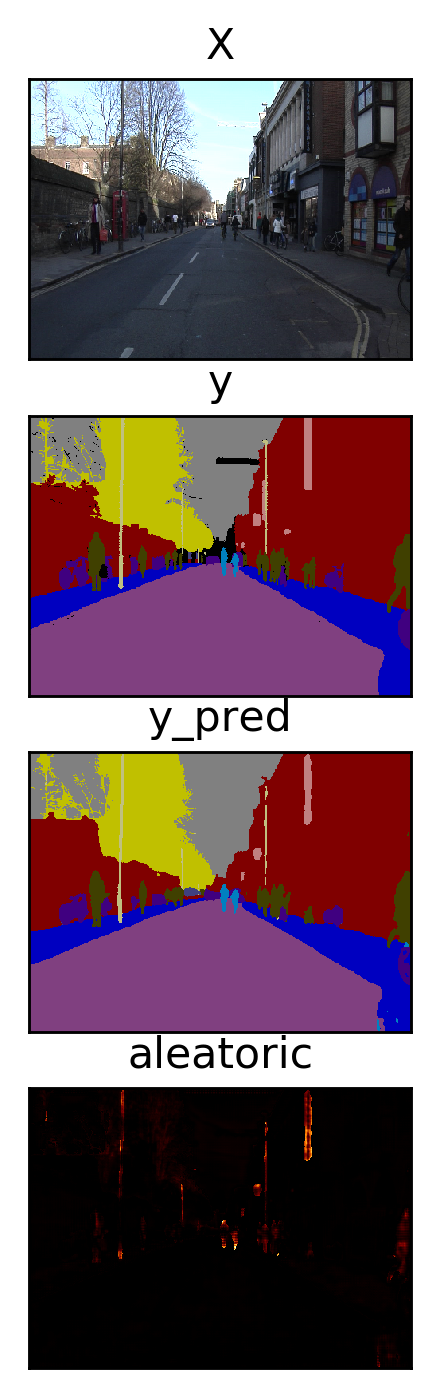

In [13]:
X, y, p, s = predict.predict_aleatoric(model, generators['train'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

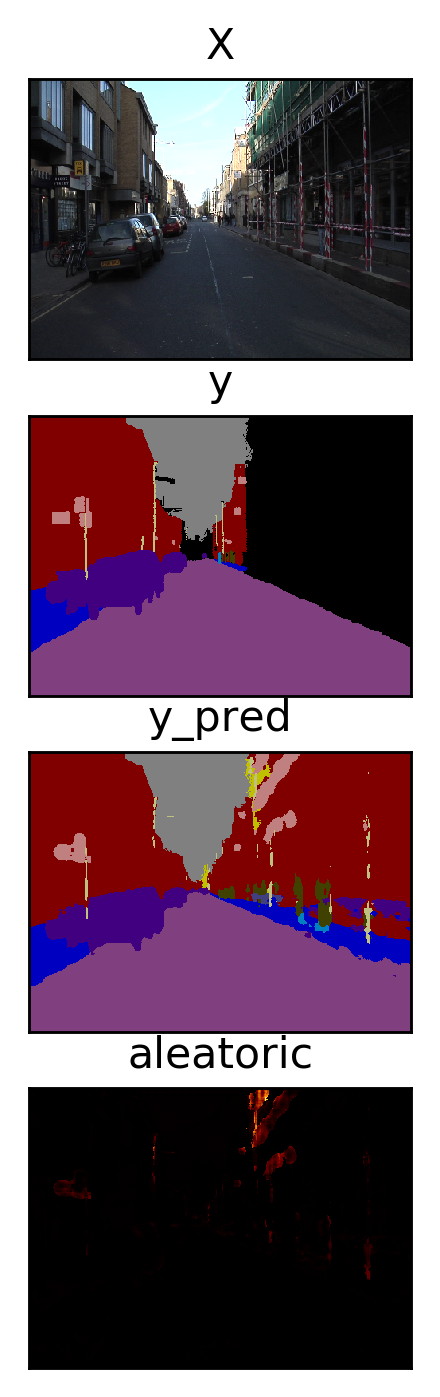

In [14]:
X, y, p, s = predict.predict_aleatoric(model, generators['train'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

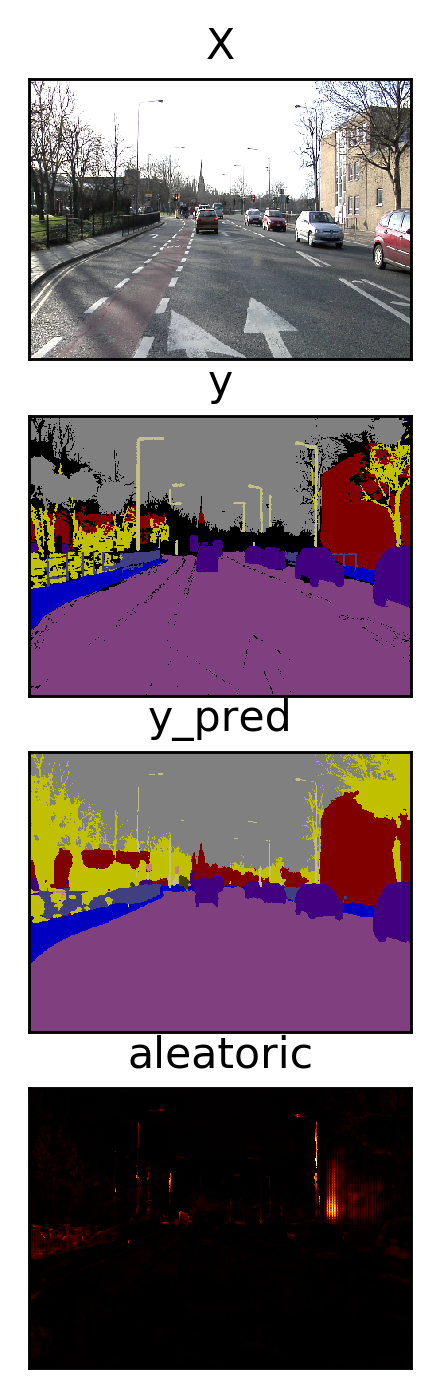

In [15]:
X, y, p, s = predict.predict_aleatoric(model, generators['train'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

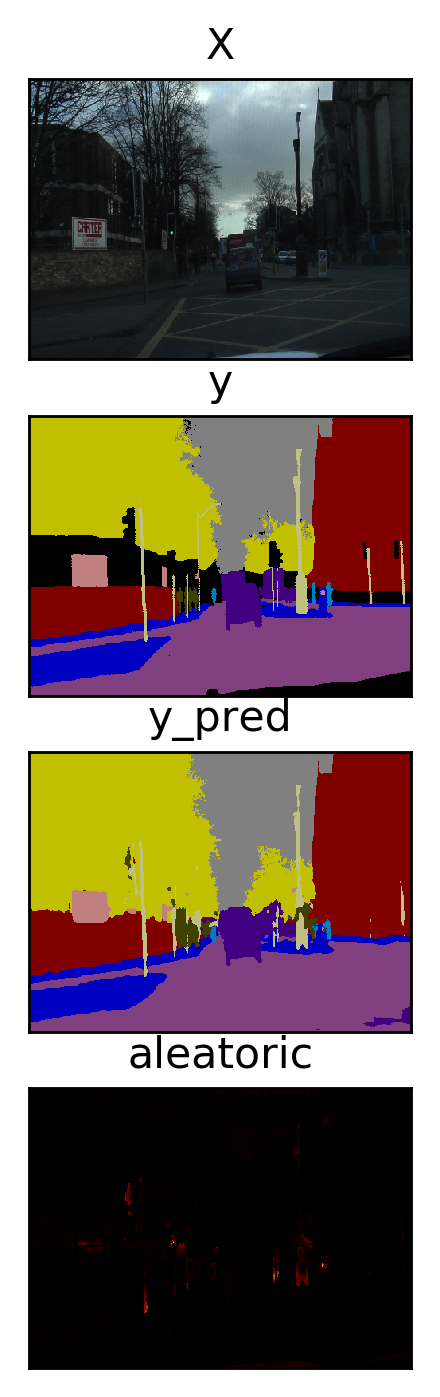

In [16]:
X, y, p, s = predict.predict_aleatoric(model, generators['train'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

### Validation

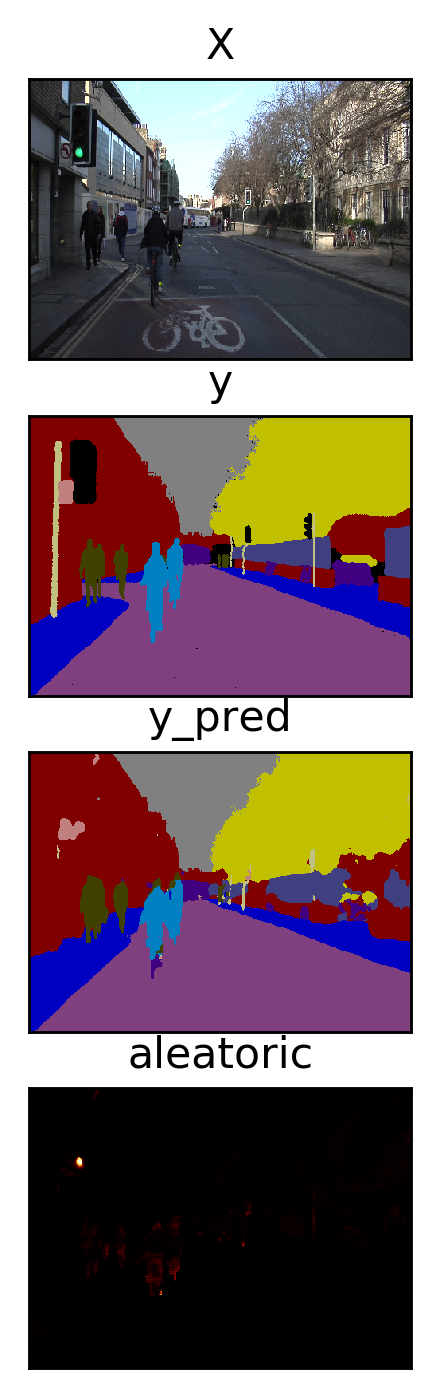

In [17]:
X, y, p, s = predict.predict_aleatoric(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

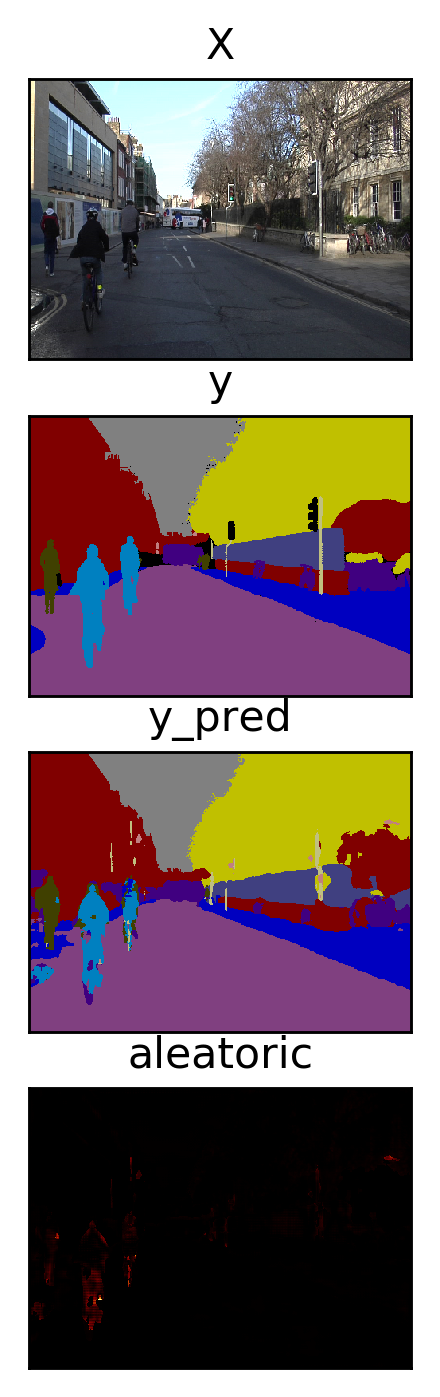

In [18]:
X, y, p, s = predict.predict_aleatoric(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

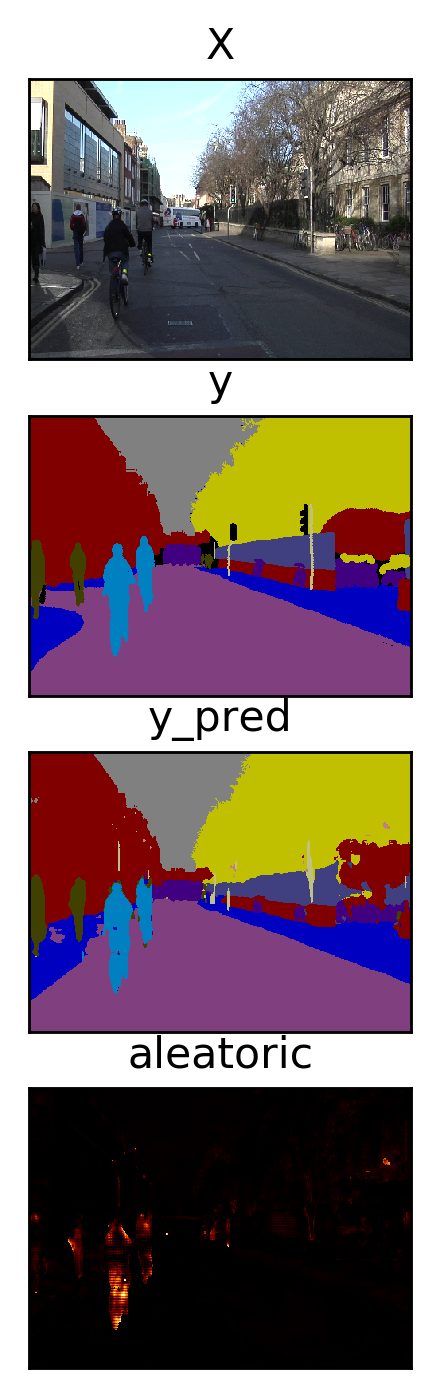

In [19]:
X, y, p, s = predict.predict_aleatoric(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

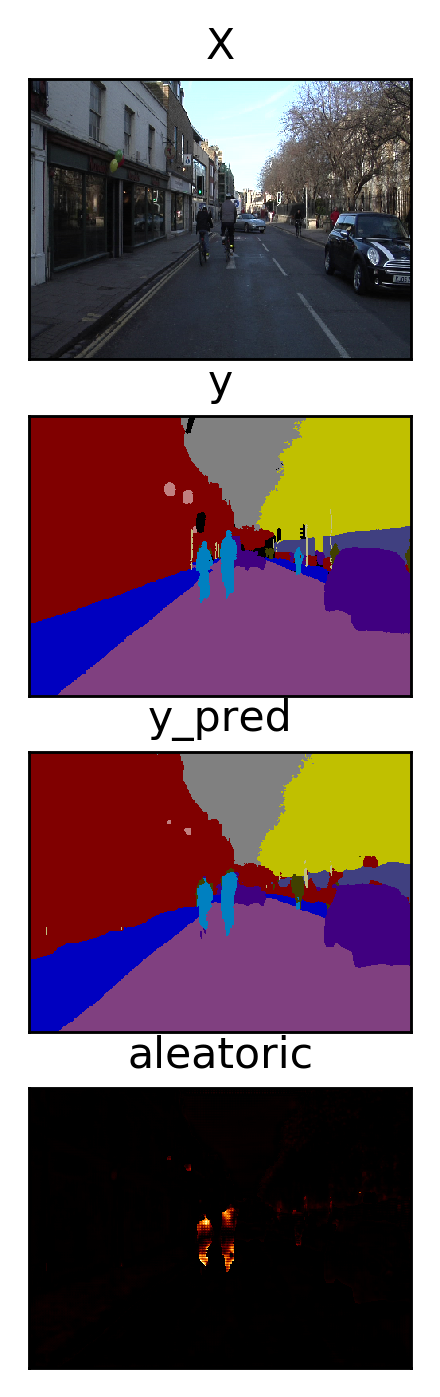

In [20]:
X, y, p, s = predict.predict_aleatoric(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])

### Test

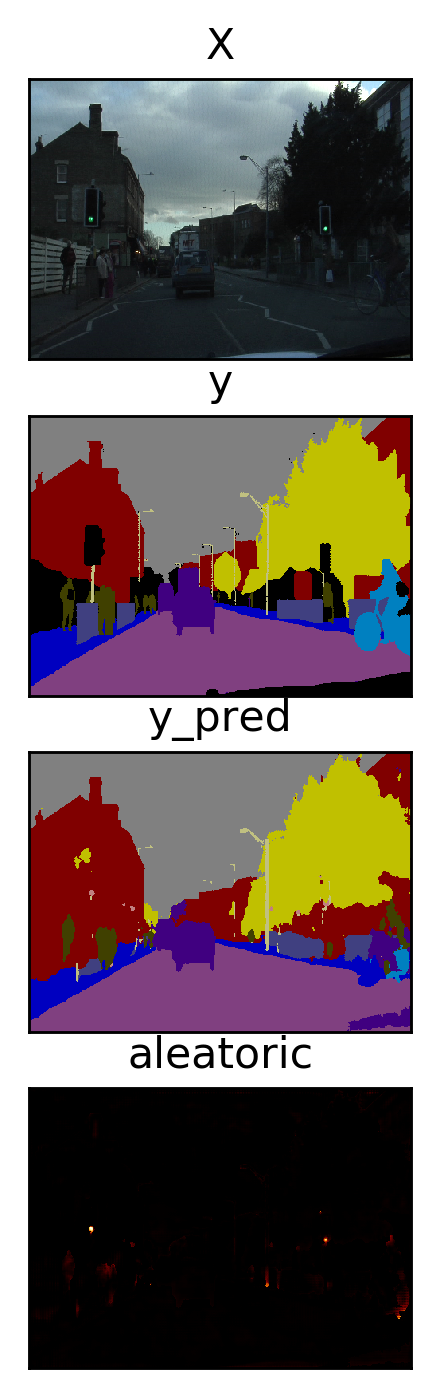

In [21]:
X, y, p, s = predict.predict_aleatoric(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])
fig.savefig('img/bayesian-tiramisu/aleatoric/0.png', transparent=True, bbox_inches='tight')

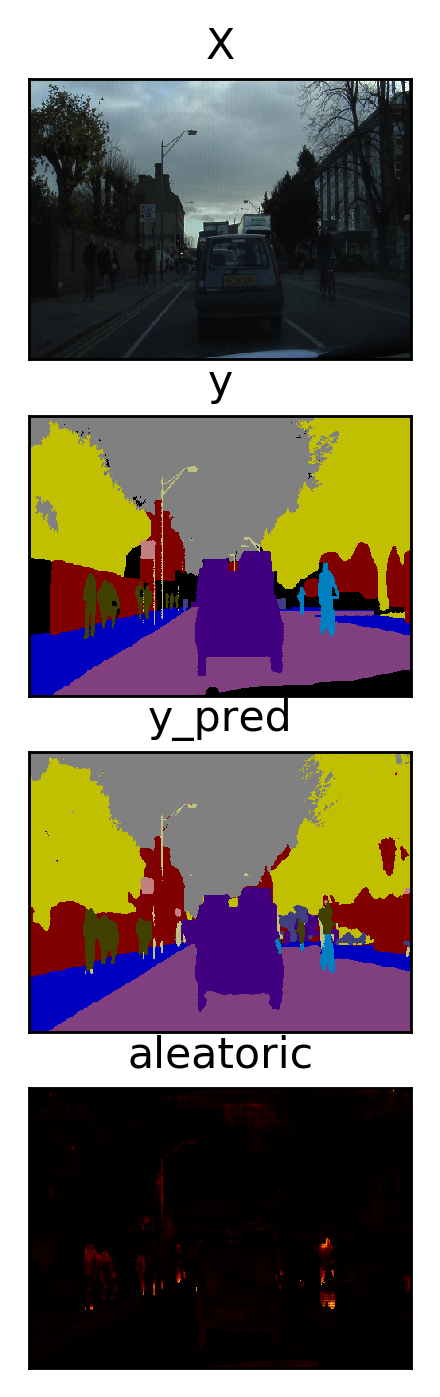

In [22]:
X, y, p, s = predict.predict_aleatoric(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])
fig.savefig('img/bayesian-tiramisu/aleatoric/1.png', transparent=True, bbox_inches='tight')

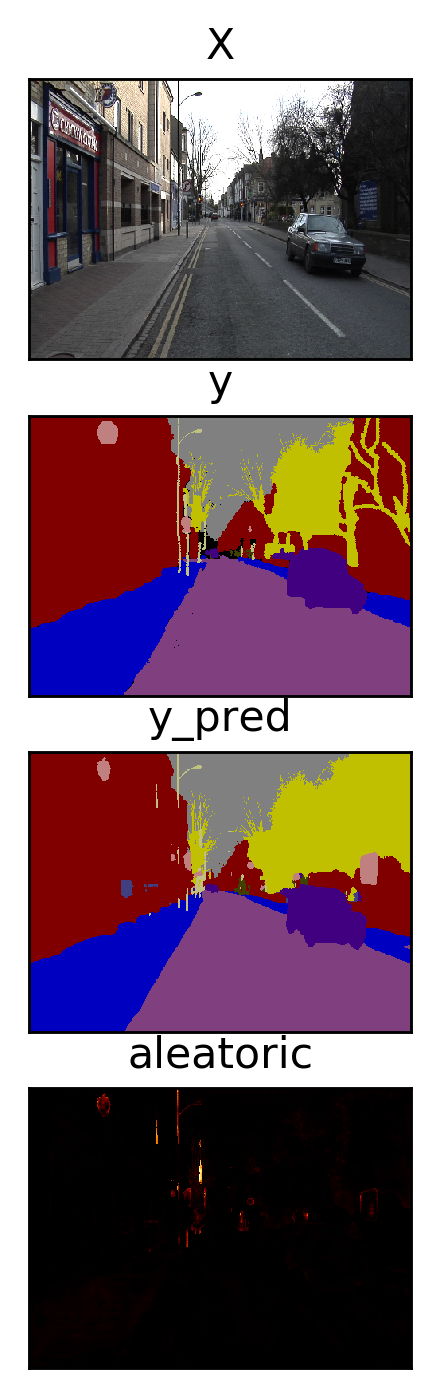

In [23]:
X, y, p, s = predict.predict_aleatoric(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])
fig.savefig('img/bayesian-tiramisu/aleatoric/2.png', transparent=True, bbox_inches='tight')

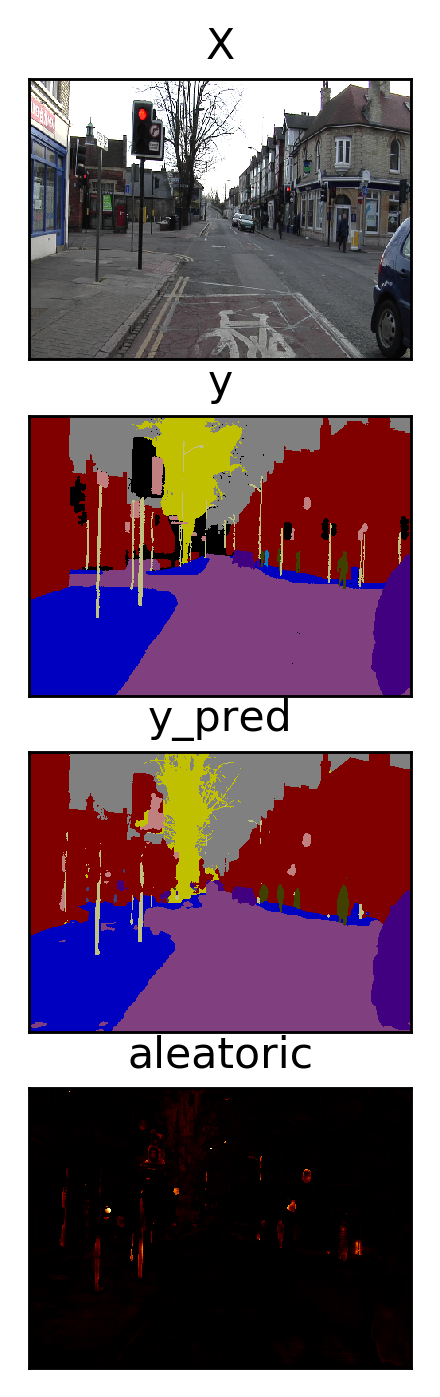

In [24]:
X, y, p, s = predict.predict_aleatoric(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], aleatoric=s[0], order=['X', 'y', 'y_pred', 'aleatoric'])
fig.savefig('img/bayesian-tiramisu/aleatoric/3.png', transparent=True, bbox_inches='tight')

# Video

In [25]:
video_file = '0005VD.mp4'
video_path = camvid.videos.abs_path(video_file)
out_path = 'img/bayesian-tiramisu/aleatoric/{}'.format(video_file)

In [26]:
predict_video.predict_video(video_path, out_path, camvid11, model, predict.predict_aleatoric)

100%|██████████| 6600/6600 [28:25<00:00,  3.87it/s]
